In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare, gaussian_kde
from scipy.special import rel_entr
import seaborn as sns
from itertools import product
import numpy as np
import os

In [46]:
# synthetic_data=pd.read_csv("WellConnect_Synthetic_Dataset.csv")
synthetic_data=pd.read_csv("gemini_2_5_pro.csv")
MODEL = "Gemini 2.5 Pro"
# MODEL = "GPT-4o" 

# Configure plot output folder
output_dir = f'plots/{MODEL}'
os.makedirs(output_dir, exist_ok=True)

## Gender comparison among depressed

What's the probability that someone is a woman/man given that they're depressed?

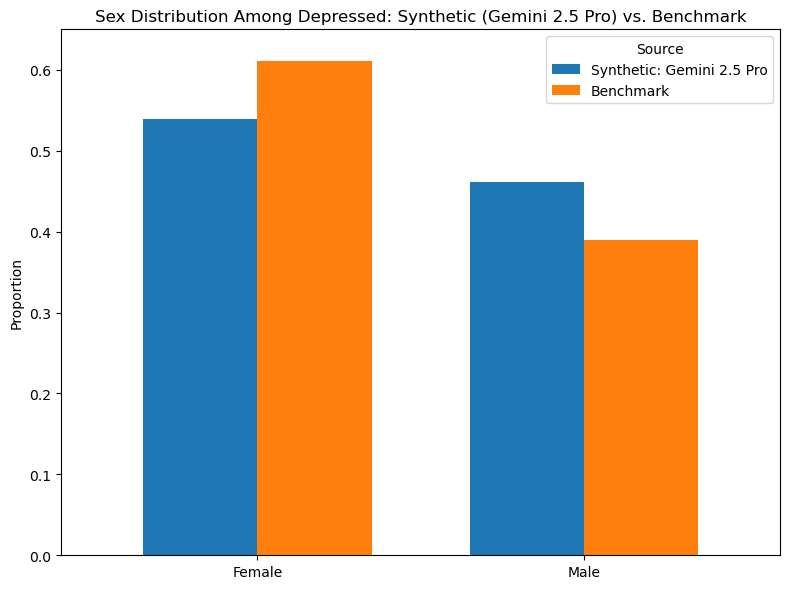

In [47]:
synthetic_data_copy = synthetic_data.copy()

#Benchmark data
P_DEP_GIVEN_F = 10.4 #staatvenz (depression prevalence)
P_DEP_GIVEN_M = 6.7 #staatvenz  (depression prevalence)
P_F = 8845204 / (8745468 + 8845204) #CBS
P_M = 8745468 / (8745468 + 8845204) #CBS
P_DEP = (P_DEP_GIVEN_F * P_F) + (P_DEP_GIVEN_M * P_M)
P_F_GIVEN_DEP = P_DEP_GIVEN_F * P_F / P_DEP
P_M_GIVEN_DEP = P_DEP_GIVEN_M * P_M / P_DEP


# Mapping
label_map = {
    'Vrouw': 'Female',
    'Man': 'Male'
}

sex_mapped = synthetic_data_copy['Sex'].map(label_map)

# Compute synthetic proportions
empirical_counts = sex_mapped.value_counts(normalize=True)
empirical = pd.Series({
    'Female': empirical_counts.get('Female', 0),
    'Male': empirical_counts.get('Male', 0)
}, name='Synthetic')

# Benchmark: P(sex | depression)
benchmark = pd.Series({
    'Female': P_F_GIVEN_DEP,
    'Male': P_M_GIVEN_DEP
}, name='Benchmark')

# Combine and plot
df_plot = pd.concat([empirical, benchmark], axis=1)

ax = df_plot.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.title(f'Sex Distribution Among Depressed: Synthetic ({MODEL}) vs. Benchmark')
plt.ylabel('Proportion')
plt.ylim(0, 0.65)
plt.xticks(rotation=0)
ax.legend([f'Synthetic: {MODEL}', 'Benchmark'], title='Source')
plt.tight_layout()
plt.savefig(f'{output_dir}/gender_among_depressed.png')
plt.show()

Significance

In [48]:
# observed and expected should be count vectors
observed = df_plot['Synthetic'].values * len(synthetic_data_copy)
expected = df_plot['Benchmark'].values * len(synthetic_data_copy)

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-squared statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")

Chi-squared statistic: 16.4563, p-value: 0.0000


## Education comparison among depressed

['HBO' 'Universiteit (Bachelor, Master, of hoger)' 'Mbo (niveau 1-4)'
 'Scholier of student, naam opleiding: …' 'Havo/Vwo' 'Basisonderwijs'
 'Vmbo/Mavo']


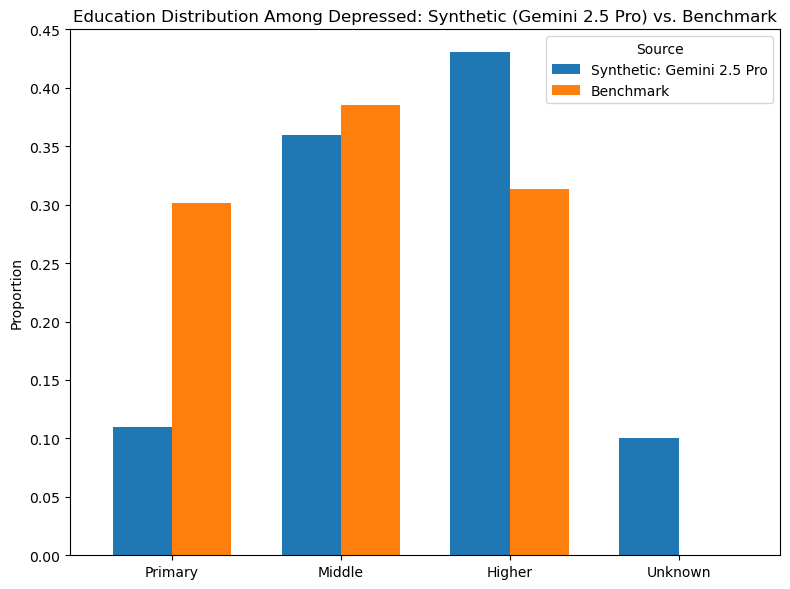

In [49]:
synthetic_data_copy = synthetic_data.copy()

# Benchmark data
P_PRIMARY_VMBO_MBO1 = 0.260 #CBS
P_HAVO_VWO_MBO2TO4 = 0.370 #CBS
P_HBO_UNI = 0.364 #CBS
P_DEP_GIVEN_PRIMARY_VMBO_MBO1 = 0.097 #staatvenz (depression prevalence)
P_DEP_GIVEN_HAVO_VWO_MBO2TO4 = 0.087 #staatvenz (depression prevalence)
P_DEP_GIVEN_HBO_UNI = 0.072 #staatvenz (depression prevalence)
P_DEP = (P_DEP_GIVEN_PRIMARY_VMBO_MBO1 * P_PRIMARY_VMBO_MBO1) + (P_DEP_GIVEN_HAVO_VWO_MBO2TO4 * P_HAVO_VWO_MBO2TO4) + (P_DEP_GIVEN_HBO_UNI * P_HBO_UNI)
P_PRIMARY_VMBO_MBO1_GIVEN_DEP = P_DEP_GIVEN_PRIMARY_VMBO_MBO1 * P_PRIMARY_VMBO_MBO1 / P_DEP
P_HAVO_VWO_MBO2TO4_GIVEN_DEP = P_DEP_GIVEN_HAVO_VWO_MBO2TO4 * P_HAVO_VWO_MBO2TO4 / P_DEP
P_HBO_UNI_GIVEN_DEP = P_DEP_GIVEN_HBO_UNI * P_HBO_UNI / P_DEP

# Define mapping from your raw education categories
edu_map = {
    'Geen opleiding': 'Primary',
    'Basisonderwijs': 'Primary',
    'Vmbo/Mavo': 'Primary',
    'Mbo (niveau 1-4)': 'Middle',  
    'Havo/Vwo': 'Middle',
    'HBO': 'Higher',
    'Universiteit (Bachelor, Master, of hoger)': 'Higher'
    # All else will fall into 'Unknown'
}
print(synthetic_data_copy['EducationLevel'].unique())

# Map education levels
edu_raw = synthetic_data_copy['EducationLevel']
edu_mapped = edu_raw.map(edu_map).fillna('Unknown')

# Compute synthetic proportions
edu_counts = edu_mapped.value_counts(normalize=True)
synthetic = pd.Series({
    'Primary': edu_counts.get('Primary', 0),
    'Middle': edu_counts.get('Middle', 0),
    'Higher': edu_counts.get('Higher', 0),
    'Unknown': edu_counts.get('Unknown', 0)
}, name='Synthetic')

# Benchmark: P(education | depression), from your prior calc
benchmark = pd.Series({
    'Primary': P_PRIMARY_VMBO_MBO1_GIVEN_DEP,
    'Middle': P_HAVO_VWO_MBO2TO4_GIVEN_DEP,
    'Higher': P_HBO_UNI_GIVEN_DEP,
    'Unknown': 1 - (P_PRIMARY_VMBO_MBO1_GIVEN_DEP + P_HAVO_VWO_MBO2TO4_GIVEN_DEP + P_HBO_UNI_GIVEN_DEP)
}, name='Benchmark')

# Combine and plot
df_plot = pd.concat([synthetic, benchmark], axis=1)

# Plot
ax = df_plot.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.title(f'Education Distribution Among Depressed: Synthetic ({MODEL}) vs. Benchmark')
plt.ylabel('Proportion')
plt.ylim(0, 0.45)
plt.xticks(rotation=0)
ax.legend([f'Synthetic: {MODEL}', 'Benchmark'], title='Source')
plt.tight_layout()
plt.savefig(f'{output_dir}/education_among_depressed.png')
plt.show()

Significance

In [50]:
# Convert proportions to counts
observed = df_plot['Synthetic'].values * len(synthetic_data_copy)
expected = df_plot['Benchmark'].values * len(synthetic_data_copy)

# Normalize expected counts to match total observed count
expected = expected * (observed.sum() / expected.sum())

# Perform chi-squared test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-squared statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")

Chi-squared statistic: inf, p-value: 0.0000


/home/guoda/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


## Age comparison among depressed

/tmp/ipykernel_5423/4035136008.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_totals = age_group_totals.groupby('AgeGroup')['Total'].sum()


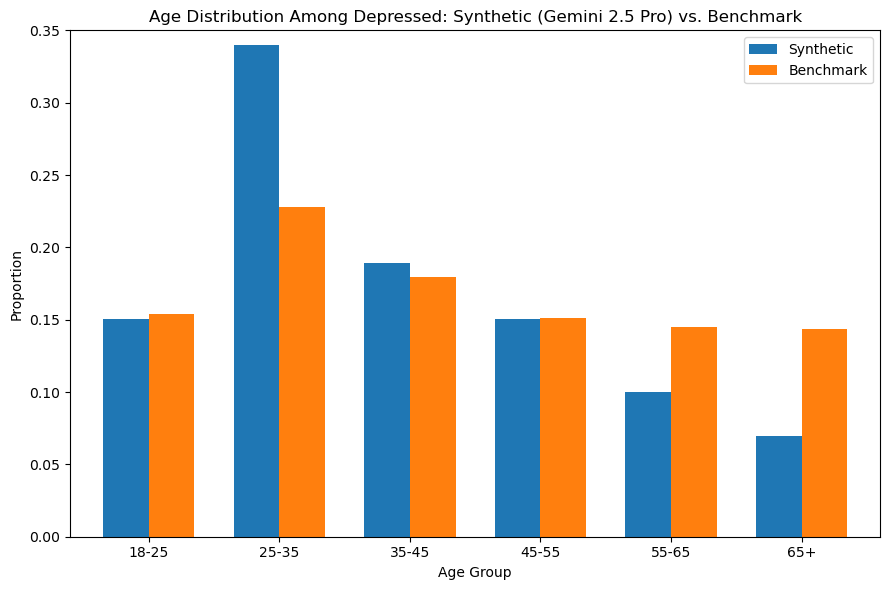

In [51]:
synthetic_data_copy = synthetic_data.copy()

# Load CBS data and process
age_group_totals = pd.read_csv("CBS Age composition in the Netherlands 2025 (estimate).csv", delimiter=';')
age_group_totals.columns = ['Age', 'Men', 'Women']

for col in ['Men', 'Women']:
    age_group_totals[col] = age_group_totals[col].str.replace(' ', '').str.replace('.', '', regex=False)
    age_group_totals[col] = pd.to_numeric(age_group_totals[col], errors='coerce').fillna(0).astype(int)


def extract_numeric_age(age_str):
    if 'or older' in age_str or '+' in age_str:
        return 105
    elif 'yrs' in age_str:
        return int(age_str.split(' ')[0])
    else:
        return None

age_group_totals['NumericAge'] = age_group_totals['Age'].apply(extract_numeric_age)
age_group_totals = age_group_totals.dropna(subset=['NumericAge'])

# Total population
age_group_totals['Total'] = age_group_totals['Men'] + age_group_totals['Women']

bins = [18, 25, 35, 45, 55, 65, 130]
labels = ['18-25', '25-35', '35-45', '45-55', '55-65', '65+']
age_group_totals['AgeGroup'] = pd.cut(age_group_totals['NumericAge'], bins=bins, labels=labels, right=False)

# Group by bins
grouped_totals = age_group_totals.groupby('AgeGroup')['Total'].sum()
total_population = grouped_totals.sum()
P_AGE_GROUP = (grouped_totals / total_population).to_dict()

# Staatvenz: P(depression | age group)
P_DEP_GIVEN = {
    '18-25': 0.115,
    '25-35': 0.114,
    '35-45': 0.096,
    '45-55': 0.081,
    '55-65': 0.070,
    '65+':   0.046
}

# Compute P(depression)
P_DEP = sum(P_DEP_GIVEN[age] * P_AGE_GROUP[age] for age in P_DEP_GIVEN)

# Compute P(age group | depression)
P_AGE_GIVEN_DEP = {
    age: (P_DEP_GIVEN[age] * P_AGE_GROUP[age]) / P_DEP
    for age in P_DEP_GIVEN
}

# Prepare synthetic data
synthetic_data_copy['AgeGroup'] = pd.cut(synthetic_data_copy['Age'], bins=bins, labels=labels, right=False)
synthetic_props = synthetic_data_copy['AgeGroup'].value_counts(normalize=True).reindex(labels, fill_value=0)

# Combine and plot
df_plot = pd.DataFrame({
    'Synthetic': synthetic_props,
    'Benchmark': pd.Series(P_AGE_GIVEN_DEP)
})

df_plot.plot(kind='bar', figsize=(9, 6), width=0.7)
plt.title(f'Age Distribution Among Depressed: Synthetic ({MODEL}) vs. Benchmark')
plt.ylabel('Proportion')
plt.xlabel('Age Group')
plt.xticks(rotation=0)
plt.ylim(0, 0.35)
ax.legend([f'Synthetic: {MODEL}', 'Benchmark'], title='Source')
plt.tight_layout()
plt.savefig(f'{output_dir}/age_among_depressed.png')
plt.show()

Significance

In [52]:
# observed and expected should be count vectors
observed = df_plot['Synthetic'].values * len(synthetic_data_copy)
expected = df_plot['Benchmark'].values * len(synthetic_data_copy)

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-squared statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")

Chi-squared statistic: 80.8814, p-value: 0.0000


## Age gender comparison among depressed (benchmark at the GP office)

/tmp/ipykernel_5423/3411580339.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['AgeGroup', 'SexMapped']).size().rename('count').reset_index()
/tmp/ipykernel_5423/3411580339.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped['Synthetic'] = grouped['count'] / grouped.groupby('AgeGroup')['count'].transform('sum')


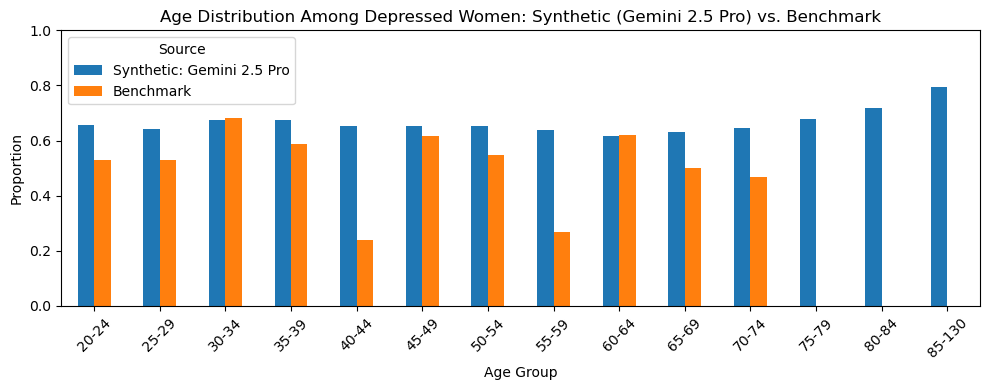

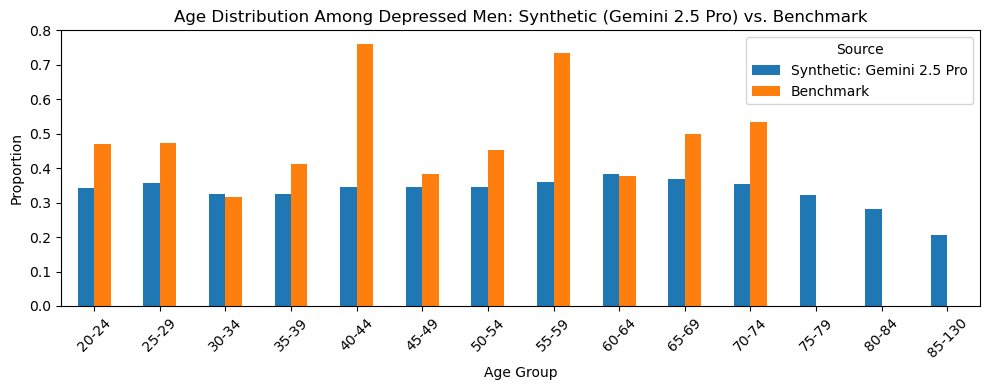

In [53]:
# Load CBS age-sex population data
cbs = pd.read_csv("CBS Age composition in the Netherlands 2025 (estimate).csv", delimiter=';')
cbs.columns = ['Age', 'Men', 'Women']
for col in ['Men', 'Women']:
    cbs[col] = cbs[col].str.replace(' ', '').str.replace('.', '', regex=False).astype(int)
cbs['NumericAge'] = cbs['Age'].str.extract(r'(\d+)').astype(int)

# Load Staatvenz depression prevalence by age-sex
staat = pd.read_csv("staatvenz_depression_prevalence_at_GP_offices.csv", delimiter=';')
staat.columns = ['AgeGroup', 'Men', 'Women']

# Helper to extract age range bounds
def parse_bounds(s):
    if '+' in s or 'ouder' in s:
        start = int(s.split()[0])
        return start, 130
    start, end = map(int, s.split()[0].split('-'))
    return start, end

# Calculate benchmark P(sex | depression, age)
bench_list = []
for _, row in staat.iterrows():
    age_lower, age_upper = parse_bounds(row['AgeGroup'])
    if age_upper < 20:
        continue  # skip child categories

    subset = cbs[(cbs['NumericAge'] >= age_lower) & (cbs['NumericAge'] <= age_upper)]
    m = subset['Men'].sum()
    f = subset['Women'].sum()
    if m + f == 0:
        continue

    pm_age = m / (m + f)
    pf_age = f / (m + f)
    pym = row['Men'] / 100
    pyf = row['Women'] / 100
    pdep_age = pym * pm_age + pyf * pf_age

    bench_list.extend([
        {'AgeGroup': f"{age_lower}-{age_upper}", 'Sex': 'Male',
         'Benchmark': (pym * pm_age) / pdep_age},
        {'AgeGroup': f"{age_lower}-{age_upper}", 'Sex': 'Female',
         'Benchmark': (pyf * pf_age) / pdep_age}
    ])
benchmark_df = pd.DataFrame(bench_list)

# Prepare synthetic data
df = synthetic_data.copy()
df['SexMapped'] = df['Sex'].map({'Man': 'Male', 'Vrouw': 'Female'})
df = df[df['Age'] >= 20]

# Align synthetic age groups to Staatvenz bins
age_bins = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,130]
age_labels = [f"{i}-{i+4}" for i in range(20,85,5)] + ['85-130']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=True)

# Compute P(sex | depression, age) in synthetic data
grouped = df.groupby(['AgeGroup', 'SexMapped']).size().rename('count').reset_index()
grouped['Synthetic'] = grouped['count'] / grouped.groupby('AgeGroup')['count'].transform('sum')
synth = grouped[['AgeGroup', 'SexMapped', 'Synthetic']].rename(columns={'SexMapped': 'Sex'})

# Merge and reshape
plot_df = pd.merge(benchmark_df, synth, on=['AgeGroup', 'Sex'], how='outer').melt(
    id_vars=['AgeGroup', 'Sex'],
    value_vars=['Benchmark', 'Synthetic'],
    var_name='Source', value_name='Proportion'
).dropna()

# Split the data by sex
plot_f = plot_df[plot_df['Sex'] == 'Female']
plot_m = plot_df[plot_df['Sex'] == 'Male']

# Plot for females
plot_f_pivot = plot_f.pivot(index='AgeGroup', columns='Source', values='Proportion')
plot_f_pivot = plot_f_pivot.reindex(age_labels)  # preserve bin order

ax = plot_f_pivot.plot(kind='bar', figsize=(10, 4))
plt.title(f"Age Distribution Among Depressed Women: Synthetic ({MODEL}) vs. Benchmark")
plt.ylabel("Proportion")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.ylim(0, 1)
ax.legend([f"Synthetic: {MODEL}", "Benchmark"], title='Source')
plt.tight_layout()
plt.savefig(f'{output_dir}/age_dist_among_depressed_females.png')
plt.show()


# Plot for males
plot_m_pivot = plot_m.pivot(index='AgeGroup', columns='Source', values='Proportion')
plot_m_pivot = plot_m_pivot.reindex(age_labels)  # preserve bin order

ax = plot_m_pivot.plot(kind='bar', figsize=(10, 4))
plt.title(f"Age Distribution Among Depressed Men: Synthetic ({MODEL}) vs. Benchmark")
plt.ylabel("Proportion")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.ylim(0, 0.8)
ax.legend([f"Synthetic: {MODEL}", "Benchmark"], title='Source')
plt.tight_layout()
plt.savefig(f'{output_dir}/age_dist_among_depressed_males.png')
plt.show()


Significance

In [54]:
# Get all unique age groups from benchmark
all_age_groups = plot_df['AgeGroup'].unique()

for sex in ['Male', 'Female']:
    sub = plot_df[plot_df['Sex'] == sex]

    # Extract and reindex with full age group list
    observed = (
        sub[sub['Source'] == 'Synthetic']
        .set_index('AgeGroup')
        .reindex(all_age_groups, fill_value=0)
        .sort_index()['Proportion']
        .values
    )

    expected = (
        sub[sub['Source'] == 'Benchmark']
        .set_index('AgeGroup')
        .reindex(all_age_groups, fill_value=0)
        .sort_index()['Proportion']
        .values
    )

    # Normalize expected to observed sum
    expected = expected * observed.sum() / expected.sum()

    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    print(f"Chi-squared test for {sex}: statistic = {chi2:.4f}, p-value = {p:.4f}")


Chi-squared test for Male: statistic = 1.6006, p-value = 0.9999
Chi-squared test for Female: statistic = 2.2015, p-value = 0.9996


## Origin, age, sex comparison among depressed

Clean the data from CBS and create a conditioal joint distribution table P(group|depression) to be comparable to synthetic data

In [55]:
# Load and process CBS population data
population_probs = pd.read_csv("CBS_population_by_origin_age_sex.csv", delimiter=';', skiprows=6)

# Extract numeric age and create age group
population_probs['Age'] = population_probs['Leeftijd'].str.extract(r'(\d+)').astype(float)
population_probs = population_probs.dropna(subset=['Age'])
bins = [25, 45, 65, float('inf')]
labels = ['25-45', '45-65', '65+']
population_probs['AgeGroup'] = pd.cut(population_probs['Age'], bins=bins, labels=labels, right=False)

# Translate column labels to English for clarity
population_probs = population_probs.rename(columns={
    'Geslacht': 'Sex',
    'Herkomstland': 'Origin',
    'aantal': 'Count'
})

# Standardize values
population_probs['Origin'] = population_probs['Origin'].replace({
    'Nederland': 'Netherlands',
    'Europa (exclusief Nederland)': 'Europe (excl. Netherlands)',
    'Buiten Europa': 'Outside Europe',
}).str.strip()

population_probs['Sex'] = population_probs['Sex'].replace({
    'Mannen': 'Male',
    'Vrouwen': 'Female',
    'Totaal mannen en vrouwen': 'Total'
}).str.strip()

# Group by AgeGroup, Sex, Origin and compute P(age, sex, origin)
grouped_pop = (
    population_probs.groupby(['AgeGroup', 'Sex', 'Origin'])['Count']
    .sum()
    .reset_index()
)

total_pop = grouped_pop['Count'].sum()
grouped_pop['P_age_sex_origin'] = grouped_pop['Count'] / total_pop

# Load and process CBS depression prevalence data
depression_raw = pd.read_csv("CBS_depression_by_origin_age_sex.csv", delimiter=';', skiprows=6, header=None)
depression_raw.columns = ['Sex', 'AgeGroup', 'Origin', 'P_dep_given']

# Standardize and clean
depression_raw['P_dep_given'] = depression_raw['P_dep_given'].str.replace(',', '.').str.replace('%', '').astype(float) / 100
depression_raw['Sex'] = depression_raw['Sex'].replace({
    'Mannen': 'Male',
    'Vrouwen': 'Female',
    'Totaal mannen en vrouwen': 'Total'
}).str.strip()

depression_raw['Origin'] = (
    depression_raw['Origin']
    .str.strip()
    .str.replace('Herkomstland: ', '', regex=False)
    .replace({
        'Nederland': 'Netherlands',
        'Europa (excl. Nederland)': 'Europe (excl. Netherlands)',
        'Buiten Europa': 'Outside Europe'
    })
    .str.strip()
)

depression_raw['AgeGroup'] = depression_raw['AgeGroup'].replace({
    '25 tot 45 jaar': '25-45',
    '45 tot 65 jaar': '45-65',
    '65 jaar of ouder': '65+'
}).str.strip()

# Filter out category 'Totaal' from both datasets
population_probs = population_probs[population_probs['Origin'] != 'Totaal']

# Merge and compute P(group | depression)
merged = pd.merge(
    grouped_pop,
    depression_raw,
    how='inner',
    left_on=['AgeGroup', 'Sex', 'Origin'],
    right_on=['AgeGroup', 'Sex', 'Origin']
)

merged['joint'] = merged['P_dep_given'] * merged['P_age_sex_origin']
P_dep = merged['joint'].sum()
merged['P_group_given_dep'] = merged['joint'] / P_dep

# Final Output
benchmark_conditionals = merged[['AgeGroup', 'Sex', 'Origin', 'P_group_given_dep']]
print(benchmark_conditionals)


   AgeGroup     Sex                      Origin  P_group_given_dep
0     25-45  Female  Europe (excl. Netherlands)           0.014698
1     25-45  Female                 Netherlands           0.060867
2     25-45  Female              Outside Europe           0.027801
3     25-45    Male  Europe (excl. Netherlands)           0.013645
4     25-45    Male                 Netherlands           0.053807
5     25-45    Male              Outside Europe           0.025738
6     25-45   Total  Europe (excl. Netherlands)           0.028308
7     25-45   Total                 Netherlands           0.114704
8     25-45   Total              Outside Europe           0.053590
9     45-65  Female  Europe (excl. Netherlands)           0.010758
10    45-65  Female                 Netherlands           0.069882
11    45-65  Female              Outside Europe           0.020417
12    45-65    Male  Europe (excl. Netherlands)           0.006361
13    45-65    Male                 Netherlands           0.05

/tmp/ipykernel_5423/1182059535.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  population_probs.groupby(['AgeGroup', 'Sex', 'Origin'])['Count']


Create a marginal distribution table for synthetic data

In [56]:
synthetic_data_copy = synthetic_data.copy()

# Recode age into CBS-compatible categories
bins = [25, 45, 65, float('inf')]
labels = ['25-45', '45-65', '65+']
synthetic_data_copy = synthetic_data_copy[synthetic_data_copy['Age'] >= 25].copy()
synthetic_data_copy['AgeGroup'] = pd.cut(synthetic_data_copy['Age'], bins=bins, labels=labels, right=False)

# Parse country and classify CBS origin categories
europe_ex_nl = {
    'Duitsland', 'Frankrijk', 'België', 'Spanje', 'Italië', 'Polen', 'Griekenland',
    'Zweden', 'Noorwegen', 'Finland', 'Denemarken', 'Oostenrijk', 'Portugal', 'Ierland',
    'Verenigd Koninkrijk', 'Roemenië', 'Bulgarije', 'Hongarije', 'Tsjechië', 'Slowakije',
    'Litouwen', 'Letland', 'Estland', 'Slovenië', 'Kroatië', 'Luxemburg', 'Malta'
}

def extract_country_of_birth(entry):
    '''Extracts the country of birth from various formats'''
    if entry in ['Nederland', 'Netherlands']:
        return 'Nederland'
    if isinstance(entry, str) and 'Anders (specifeer):' in entry:
        return entry.split(':', 1)[-1].strip()
    if isinstance(entry, str):
        return entry.strip()  # allow direct country names like "Turkije"
    return None

def extract_base_country_CBS(row):
    '''Extracts the base country of origin based on CBS new classification starting 2022'''
    self_country = extract_country_of_birth(row.get('CountryOfBirth'))
    mother_country = extract_country_of_birth(row.get('CountryOfBirthMother'))
    father_country = extract_country_of_birth(row.get('CountryOfBirthFather'))

    if self_country != 'Nederland':
        return self_country
    elif mother_country == 'Nederland' and father_country == 'Nederland':
        return 'Nederland'
    elif mother_country and mother_country != 'Nederland':
        return mother_country
    elif father_country and father_country != 'Nederland':
        return father_country
    else:
        return None

def classify_origin(country):
    '''Classifies the country into CBS Level 1 origin categories'''
    if country == 'Nederland':
        return 'Netherlands'
    elif country in europe_ex_nl:
        return 'Europe (excl. Netherlands)'
    elif isinstance(country, str):
        return 'Outside Europe'
    return None

synthetic_data_copy['BaseCountry'] = synthetic_data_copy.apply(extract_base_country_CBS, axis=1)
synthetic_data_copy['Origin'] = synthetic_data_copy['BaseCountry'].apply(classify_origin)
synthetic_data_copy = synthetic_data_copy[synthetic_data_copy['Origin'].notna()]  # Keep only valid origins

# Map gender to english terms for clarity
synthetic_data_copy['Sex'] = synthetic_data_copy['Sex'].replace({ 
    'Man': 'Male',
    'Vrouw': 'Female'
}).str.strip()

synthetic_data_copy = synthetic_data_copy[synthetic_data_copy['Sex'].isin(['Male', 'Female'])]

# Group by AgeGroup, Sex, Origin
grouped = (
    synthetic_data_copy.groupby(['AgeGroup', 'Sex', 'Origin'])
    .size()
    .reset_index(name='count')
)

# Add totals across Sex for each AgeGroup and Origin
totals = (
    grouped.groupby(['AgeGroup', 'Origin'], observed=True)['count']
    .sum()
    .reset_index()
)
totals['Sex'] = 'Total'

# Combine detailed and totals
combined = pd.concat([grouped, totals], ignore_index=True)

# Add missing categories with count = 0
age_groups = ['25-45', '45-65', '65+']
sexes = ['Male', 'Female', 'Total']
origins = ['Netherlands', 'Europe (excl. Netherlands)', 'Outside Europe']

full_index = pd.DataFrame(list(product(age_groups, sexes, origins)), columns=['AgeGroup', 'Sex', 'Origin'])

grouped_full = pd.merge(full_index, combined, on=['AgeGroup', 'Sex', 'Origin'], how='left')
grouped_full['count'] = grouped_full['count'].fillna(0).astype(int)

# Compute probabilities
grouped_full['P_group_given_dep'] = grouped_full['count'] / grouped_full['count'].sum()

# Final output
synthetic_conditionals = grouped_full[['AgeGroup', 'Sex', 'Origin', 'P_group_given_dep']]
print(synthetic_conditionals.sort_values(by=['AgeGroup', 'Sex', 'Origin']))

   AgeGroup     Sex                      Origin  P_group_given_dep
4     25-45  Female  Europe (excl. Netherlands)           0.011774
3     25-45  Female                 Netherlands           0.083987
5     25-45  Female              Outside Europe           0.068289
1     25-45    Male  Europe (excl. Netherlands)           0.011774
0     25-45    Male                 Netherlands           0.074568
2     25-45    Male              Outside Europe           0.061224
7     25-45   Total  Europe (excl. Netherlands)           0.023548
6     25-45   Total                 Netherlands           0.158556
8     25-45   Total              Outside Europe           0.129513
13    45-65  Female  Europe (excl. Netherlands)           0.000000
12    45-65  Female                 Netherlands           0.070644
14    45-65  Female              Outside Europe           0.011774
10    45-65    Male  Europe (excl. Netherlands)           0.000000
9     45-65    Male                 Netherlands           0.05

/tmp/ipykernel_5423/3020406045.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synthetic_data_copy.groupby(['AgeGroup', 'Sex', 'Origin'])


Plot conditional joint distributions to compare

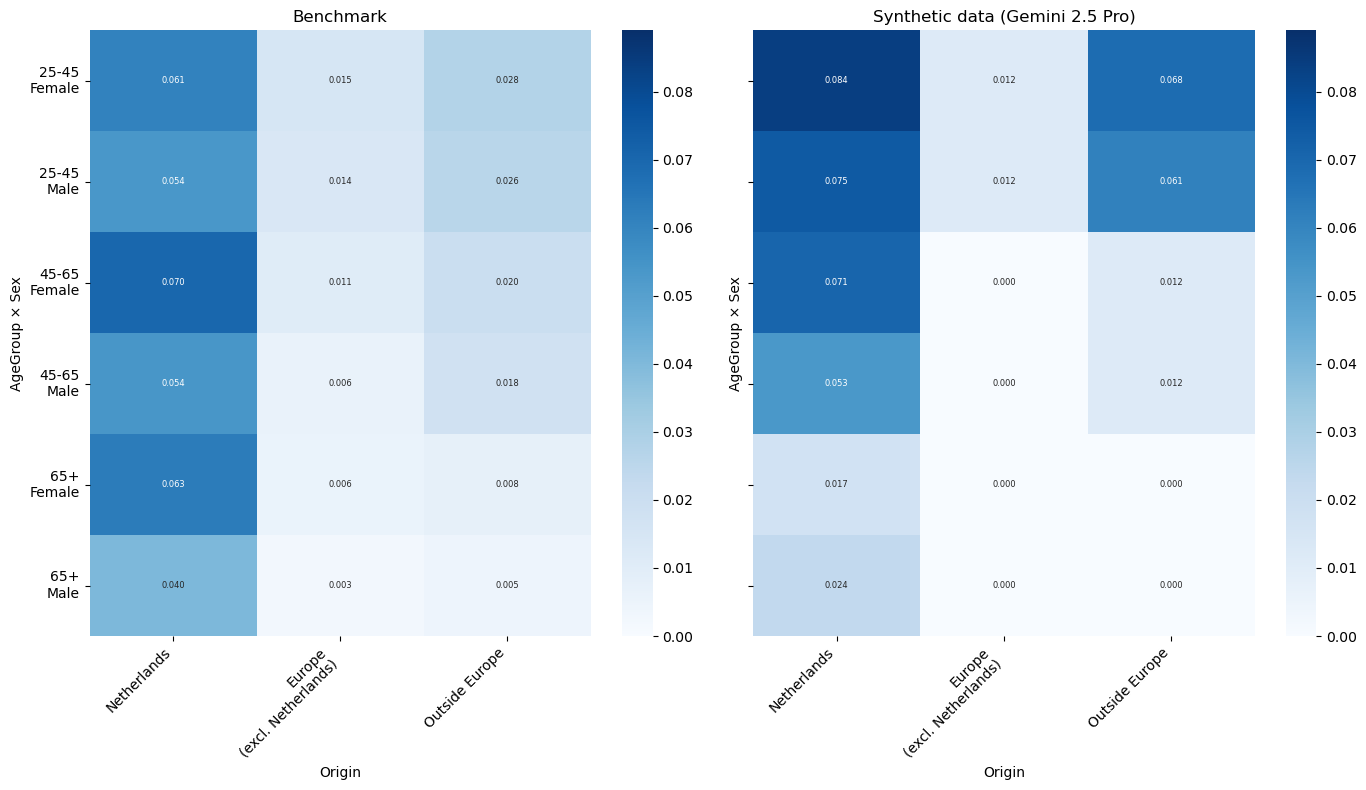

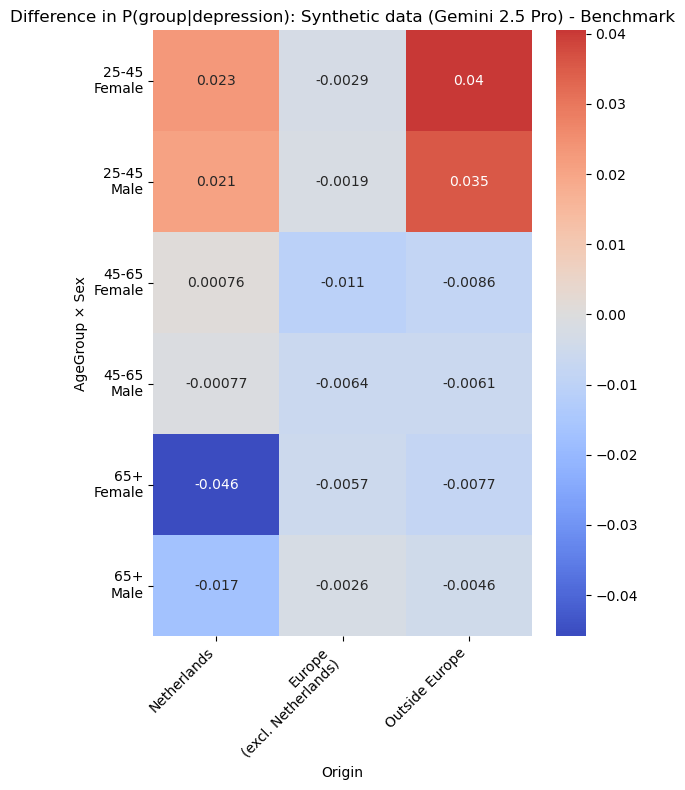

In [57]:
def prepare_heatmap_data(df, label):
    df = df[df['Sex'] != 'Total'].copy()
    df['Group'] = df['AgeGroup'] + '\n' + df['Sex']  # wrap AgeGroup and Sex
    df['Origin'] = df['Origin'].str.replace(" \\(", "\n(", regex=True)  # wrap Origin
    df['Dataset'] = label
    return df[['Group', 'Origin', 'P_group_given_dep', 'Dataset']]
    
heat_bench = prepare_heatmap_data(benchmark_conditionals, 'Benchmark')
heat_user = prepare_heatmap_data(synthetic_conditionals, 'Synthetic data')

heat_all = pd.concat([heat_bench, heat_user], ignore_index=True)

heatmap_data = {}
for name in ['Benchmark', 'Synthetic data']:
    subset = heat_all[heat_all['Dataset'] == name]
    pivoted = subset.pivot(index='Group', columns='Origin', values='P_group_given_dep')
    heatmap_data[name] = pivoted

origin_order = [
    'Netherlands',
    'Europe\n(excl. Netherlands)',
    'Outside Europe'
]

for name in heatmap_data:
    heatmap_data[name] = heatmap_data[name].reindex(columns=origin_order)

vmax = round(heat_all['P_group_given_dep'].max() + 0.005, 3)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

for ax, (title, data) in zip(axes, heatmap_data.items()):
    sns.heatmap(data, ax=ax, annot=True, cmap='Blues', vmin=0, vmax=vmax, fmt=".3f", annot_kws={"fontsize": 6})
    ax.set_yticks(np.arange(len(data.index)) + 0.5)
    ax.set_yticklabels(data.index.tolist(), fontsize=10, rotation=0)
    ax.set_xticklabels(data.columns.tolist(), rotation=45, ha='right', fontsize=10)
    
    if title == "Synthetic data":
        ax.set_title(f"Synthetic data ({MODEL})")
    else:
        ax.set_title("Benchmark")

    ax.set_xlabel('Origin')
    ax.set_ylabel('AgeGroup × Sex')

plt.tight_layout()
plt.show()

# Difference plot
diff = heatmap_data['Synthetic data'] - heatmap_data['Benchmark']
plt.figure(figsize=(7, 8))
ax = sns.heatmap(diff, annot=True, cmap='coolwarm', center=0)
ax.set_yticks(np.arange(len(diff.index)) + 0.5)
ax.set_yticklabels(diff.index.tolist(), fontsize=10, rotation=0)
ax.set_xticklabels(diff.columns.tolist(), rotation=45, ha='right', fontsize=10)
plt.title(f'Difference in P(group|depression): Synthetic data ({MODEL}) - Benchmark')
plt.xlabel('Origin')
plt.ylabel('AgeGroup × Sex')
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()


Significance

In [58]:
p = np.array(synthetic_conditionals['P_group_given_dep'])
q = np.array(benchmark_conditionals['P_group_given_dep'])

kl_div = np.sum(rel_entr(p, q))
print(f"KL divergence (Synthetic data || Benchmark): {kl_div:.4f}")



KL divergence (Synthetic data || Benchmark): 1.3100


# Ethnicity distribution

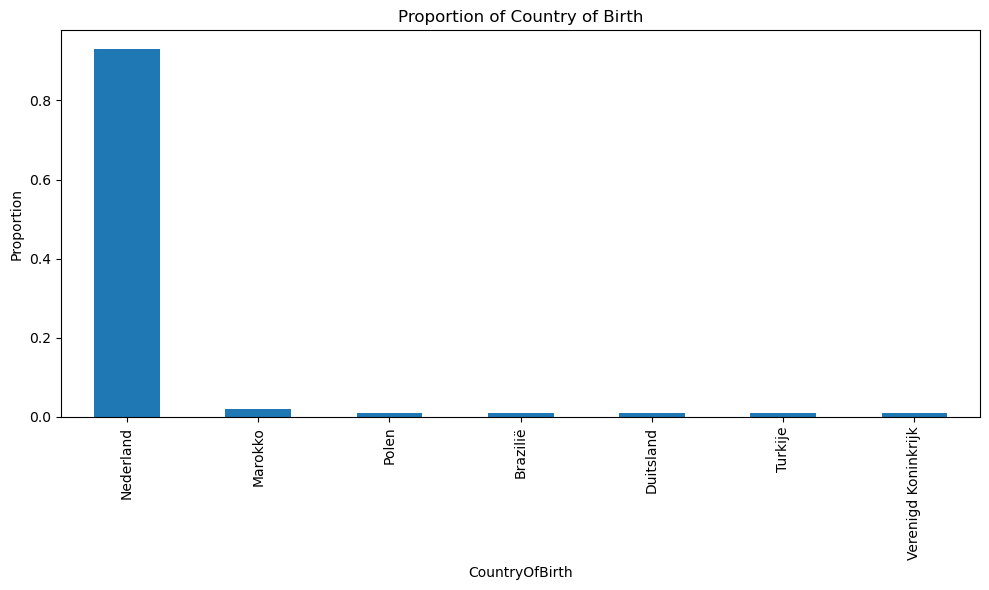

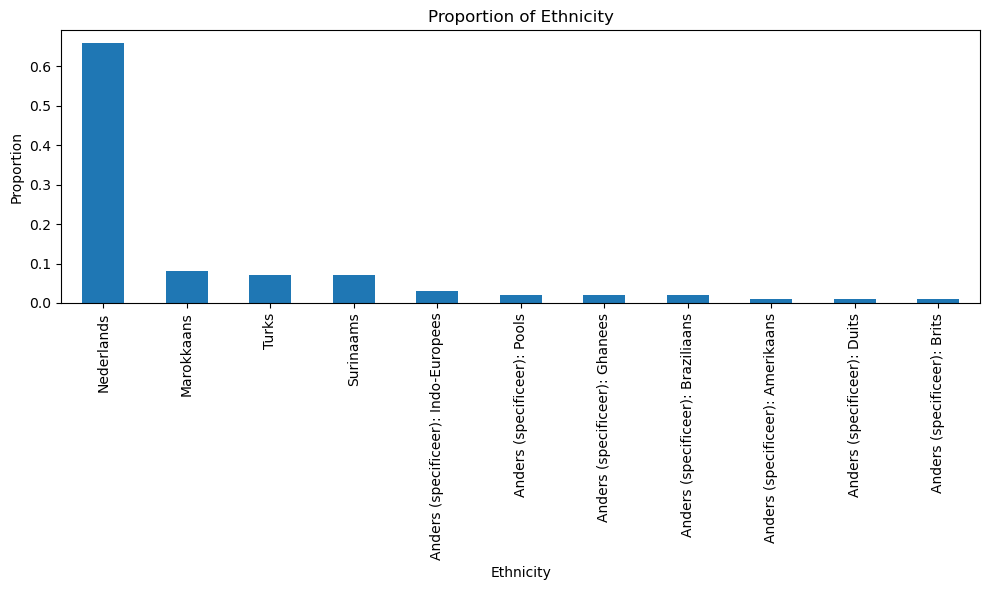

In [59]:
synthetic_data_copy = synthetic_data.copy()

# Plot: Country of Birth (proportions)
synthetic_data_copy["CountryOfBirth"].value_counts(normalize=True).plot(kind='bar', figsize=(10, 6))
plt.ylabel("Proportion")
plt.title("Proportion of Country of Birth")
plt.tight_layout()
plt.show()

# Plot: Ethnicity (proportions)
synthetic_data_copy["Ethnicity"].value_counts(normalize=True).plot(kind='bar', figsize=(10, 6))
plt.ylabel("Proportion")
plt.title("Proportion of Ethnicity")
plt.tight_layout()
plt.show()


# Religion

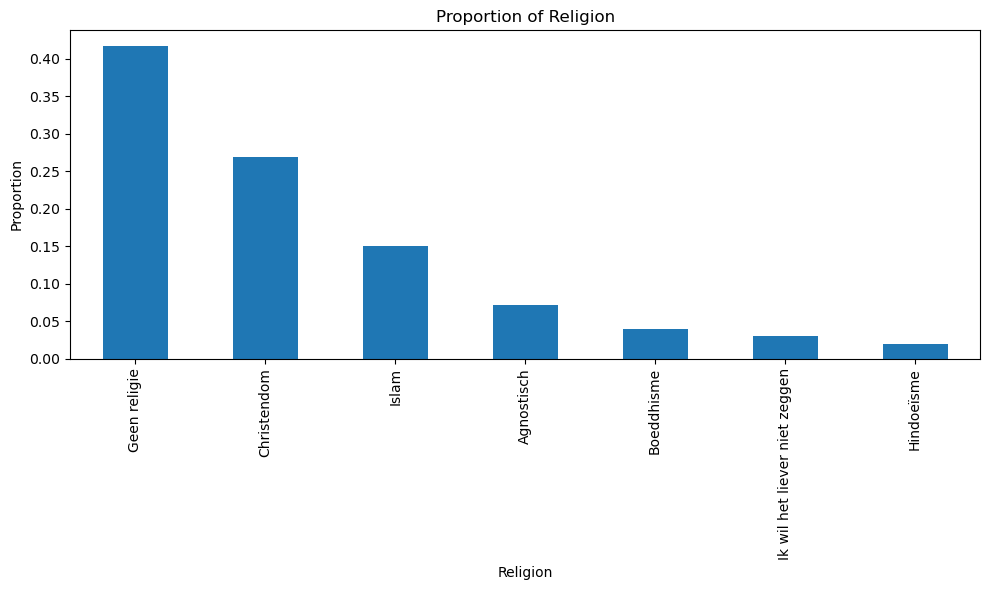

In [60]:
# Plot: Religion (proportions)
synthetic_data_copy["Religion"].value_counts(normalize=True).plot(kind='bar', figsize=(10, 6))
plt.ylabel("Proportion")
plt.title("Proportion of Religion")
plt.tight_layout()
plt.show()

## Personality

/tmp/ipykernel_5423/2206629516.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('AgeGroup')[trait_cols].mean().reset_index()
/tmp/ipykernel_5423/2206629516.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('AgeGroup')[trait_cols].std().reset_index()


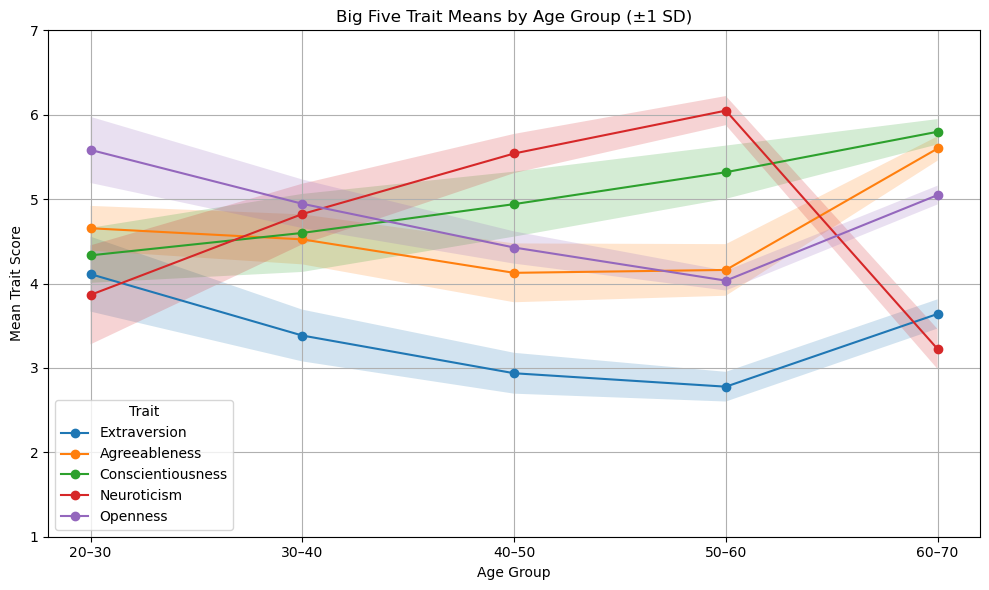

In [61]:
synthetic_data_copy = synthetic_data.copy()

# Big Five columns
trait_cols = [
    'TIPI_Extraversion',
    'TIPI_Agreeableness',
    'TIPI_Conscientiousness',
    'TIPI_Neuroticism',
    'TIPI_Openness'
]

# Age bin setup
bins = [20, 30, 40, 50, 60, 70]
labels = ['20–30', '30–40', '40–50', '50–60', '60–70']

df = synthetic_data_copy.copy()
df = df[df['Age'] >= 20].copy()
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Compute means and std devs
means = df.groupby('AgeGroup')[trait_cols].mean().reset_index()
stds = df.groupby('AgeGroup')[trait_cols].std().reset_index()

# Melt to long format
means_long = means.melt(id_vars='AgeGroup', var_name='Trait', value_name='Mean')
stds_long = stds.melt(id_vars='AgeGroup', var_name='Trait', value_name='SD')

# Merge means and stds
merged = pd.merge(means_long, stds_long, on=['AgeGroup', 'Trait'])

# Clean trait names
merged['Trait'] = merged['Trait'].str.replace('TIPI_', '')

# Plot
plt.figure(figsize=(10, 6))
for trait in merged['Trait'].unique():
    sub = merged[merged['Trait'] == trait]
    x = sub['AgeGroup']
    y = sub['Mean']
    yerr = sub['SD']

    plt.plot(x, y, marker='o', label=trait)
    plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

plt.title('Big Five Trait Means by Age Group (±1 SD)')
plt.xlabel('Age Group')
plt.ylabel('Mean Trait Score')
plt.ylim(1, 7)
plt.legend(title='Trait')
plt.grid(True)
plt.tight_layout()
plt.show()


Symptom severity

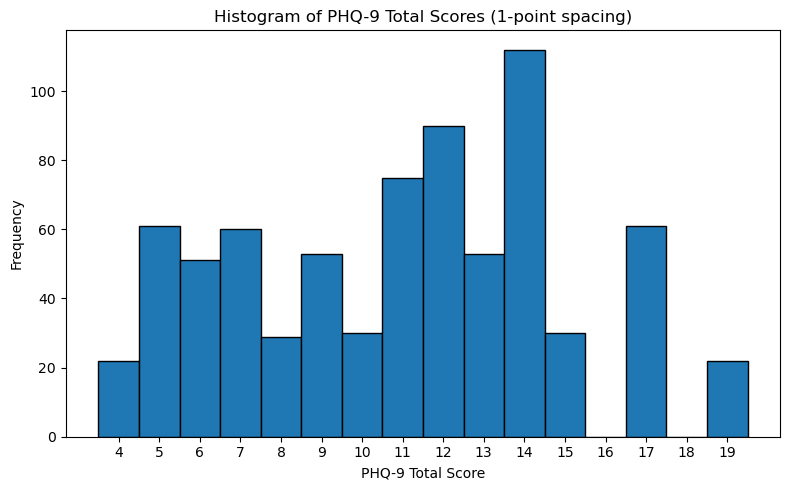

In [62]:
# Drop missing values
data = synthetic_data_copy['PHQ9_Total'].dropna()

# Determine integer range
min_val = int(data.min())
max_val = int(data.max())

# Set bin edges so each integer gets its own bin: [4.5, 5.5), [5.5, 6.5), etc.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, edgecolor='black')

# Integer-spaced x-axis ticks
plt.xticks(np.arange(min_val, max_val + 1, 1))
plt.xlabel('PHQ-9 Total Score')
plt.ylabel('Frequency')
plt.title('Histogram of PHQ-9 Total Scores (1-point spacing)')
plt.tight_layout()
plt.show()


## The code used by gemini 2.5 pro

In [63]:
# import pandas as pd

# import numpy as np

# import random

# import uuid

 

 

# def generate_phq9_scores():

#     """

#     Generates correlated PHQ-9 scores, ensuring the total score

#     is mostly in the mild-to-moderate range (5-15).

#     """

#     # Generate total score with a distribution centered on mild/moderate

#     total_score = int(

#         np.clip(np.random.normal(loc=11, scale=3.5), 2, 22)

#     )

 

#     # Distribute the total score among the 9 questions

#     questions = np.zeros(9, dtype=int)

#     for _ in range(total_score):

#         # Find questions that can still be incremented

#         eligible_indices = np.where(questions < 3)[0]

#         if len(eligible_indices) == 0:

#             # This can happen if the total score is > 27, but we clipped it.

#             # Or if distribution is unlucky. Re-balance if needed.

#             break

#         # Pick one eligible question at random and increment it

#         choice = random.choice(eligible_indices)

#         questions[choice] += 1

 

#     # Ensure the sum is exactly the generated total

#     while questions.sum() < total_score:

#         eligible_indices = np.where(questions < 3)[0]

#         if len(eligible_indices) == 0:

#             break

#         choice = random.choice(eligible_indices)

#         questions[choice] += 1

#     # In the rare case of overshoot, decrement

#     while questions.sum() > total_score:

#         eligible_indices = np.where(questions > 0)[0]

#         if len(eligible_indices) == 0:

#             break

#         choice = random.choice(eligible_indices)

#         questions[choice] -= 1

 

#     phq9_data = {f"PHQ9_q{i+1}": questions[i] for i in range(9)}

#     phq9_data["PHQ9_Total"] = questions.sum()

#     return phq9_data

 

 

# def generate_correlated_scores(phq9_total):

#     """

#     Generates TIPI and PANCRS scores correlated with depression severity.

#     """

#     # Normalize PHQ-9 score (0 to 1) for correlation base

#     phq9_norm = phq9_total / 27.0

 

#     # TIPI Scores (1.0-7.0)

#     # Neuroticism positively correlated with PHQ-9

#     neuro_base = 1.5 + phq9_norm * 5.0

#     neuroticism = np.clip(

#         np.random.normal(loc=neuro_base, scale=0.8), 1.0, 7.0

#     )

#     # Extraversion negatively correlated with PHQ-9

#     extra_base = 6.0 - phq9_norm * 4.0

#     extraversion = np.clip(

#         np.random.normal(loc=extra_base, scale=1.0), 1.0, 7.0

#     )

#     # Other TIPI scores are more random

#     agreeableness = np.clip(np.random.normal(loc=4.8, scale=1.0), 1.0, 7.0)

#     conscientiousness = np.clip(

#         np.random.normal(loc=5.0, scale=1.2), 1.0, 7.0

#     )

#     openness = np.clip(np.random.normal(loc=5.2, scale=1.0), 1.0, 7.0)

 

#     # PANCRS Scores (1.0-5.0)

#     # Negative co-rumination correlated with neuroticism/PHQ-9

#     neg_base = 1.5 + (neuroticism / 7.0) * 3.0

#     worry_eval = np.clip(

#         np.random.normal(loc=neg_base, scale=0.6), 1.0, 5.0

#     )

#     inhibit_happy = np.clip(

#         np.random.normal(loc=neg_base, scale=0.6), 1.0, 5.0

#     )

#     worry_impact = np.clip(

#         np.random.normal(loc=neg_base, scale=0.6), 1.0, 5.0

#     )

#     slack = np.clip(np.random.normal(loc=neg_base - 0.5, scale=0.7), 1.0, 5.0)

#     pancrs_total_negative = np.mean(

#         [worry_eval, inhibit_happy, worry_impact, slack]

#     )

 

#     # Positive co-rumination less correlated

#     pos_base = 4.5 - (neuroticism / 7.0) * 2.0

#     affirmation = np.clip(

#         np.random.normal(loc=pos_base, scale=0.6), 1.0, 5.0

#     )

#     problem_solving = np.clip(

#         np.random.normal(loc=pos_base - 0.4, scale=0.6), 1.0, 5.0

#     )

#     enhancing_friendship = np.clip(

#         np.random.normal(loc=pos_base, scale=0.6), 1.0, 5.0

#     )

#     pancrs_total_positive = np.mean(

#         [affirmation, problem_solving, enhancing_friendship]

#     )

 

#     # Frequency scores

#     freq_pos = np.clip(

#         pancrs_total_positive - np.random.normal(0, 0.3), 1.0, 5.0

#     )

#     freq_neg = np.clip(

#         pancrs_total_negative - np.random.normal(0, 0.3), 1.0, 5.0

#     )

#     pancrs_total_freq = np.mean([freq_pos, freq_neg])

 

#     return {

#         "TIPI_Extraversion": round(extraversion, 1),

#         "TIPI_Agreeableness": round(agreeableness, 1),

#         "TIPI_Conscientiousness": round(conscientiousness, 1),

#         "TIPI_Neuroticism": round(neuroticism, 1),

#         "TIPI_Openness": round(openness, 1),

#         "PANCRS_Affirmation": round(affirmation, 1),

#         "PANCRS_ProblemSolving": round(problem_solving, 1),

#         "PANCRS_EnhancingFriendship": round(enhancing_friendship, 1),

#         "PANCRS_TotalPositive": round(pancrs_total_positive, 1),

#         "PANCRS_WorryAboutEvaluation": round(worry_eval, 1),

#         "PANCRS_InhibitingHappiness": round(inhibit_happy, 1),

#         "PANCRS_WorryAboutImpact": round(worry_impact, 1),

#         "PANCRS_Slack": round(slack, 1),

#         "PANCRS_TotalNegative": round(pancrs_total_negative, 1),

#         "PANCRS_FrequencyPositive": round(freq_pos, 1),

#         "PANCRS_FrequencyNegative": round(freq_neg, 1),

#         "PANCRS_TotalFrequency": round(pancrs_total_freq, 1),

#     }

 

 

# def generate_demographics():

#     """

#     Generates realistic demographic data for a participant in Amsterdam.

#     """

#     # Age distribution

#     age = int(

#         np.clip(

#             np.random.normal(loc=38, scale=15), 18, 85

#         )  # Centered around late 30s

#     )

 

#     # Sex and Gender

#     sex = random.choices(["Vrouw", "Man"], weights=[0.52, 0.48], k=1)[0]

#     if random.random() < 0.98:

#         gender = sex

#     else:

#         gender = random.choice(

#             ["Trans man", "Trans woman", "Non-binary", "Other"]

#         )

 

#     # Ethnicity and Country of Birth (based on Amsterdam stats)

#     ethnicities = [

#         "Nederlands",

#         "Marokkaans",

#         "Surinaams",

#         "Turks",

#         "Anders (specificeer): __________",

#         "Ik wil het liever niet zeggen",

#     ]

#     # Approximate weights for Amsterdam

#     weights = [0.52, 0.11, 0.09, 0.06, 0.18, 0.04]

#     ethnicity = random.choices(ethnicities, weights=weights, k=1)[0]

 

#     country_of_birth_mother = "Nederland"

#     country_of_birth_father = "Nederland"

#     country_of_birth = "Nederland"

#     nationality = "Nederlands"

 

#     if ethnicity == "Marokkaans":

#         if random.random() < 0.6:  # First generation

#             country_of_birth = "Marokko"

#             nationality = "Marokkaans"

#         country_of_birth_mother = "Marokko"

#         country_of_birth_father = "Marokko"

#     elif ethnicity == "Turks":

#         if random.random() < 0.55:

#             country_of_birth = "Turkije"

#             nationality = "Turks"

#         country_of_birth_mother = "Turkije"

#         country_of_birth_father = "Turkije"

#     elif ethnicity == "Surinaams":

#         if random.random() < 0.4:

#             country_of_birth = "Suriname"

#         country_of_birth_mother = "Suriname"

#         country_of_birth_father = "Suriname"

#     elif "Anders" in ethnicity:

#         other_countries = [

#             "Duitsland",

#             "Verenigd Koninkrijk",

#             "Polen",

#             "Indonesië",

#             "Ghana",

#             "Brazilië",

#             "Verenigde Staten",

#         ]

#         chosen_country = random.choice(other_countries)

#         ethnicity = f"Anders (specificeer): {chosen_country}"

#         if random.random() < 0.8:  # Assume most are immigrants

#             country_of_birth = chosen_country

#             nationality = f"{chosen_country}"

#             country_of_birth_mother = chosen_country

#             country_of_birth_father = chosen_country

#         else:  # Or second gen

#             country_of_birth_mother = chosen_country

#             country_of_birth_father = chosen_country

 

#     # Education Level

#     edu_levels = [

#         "Geen opleiding",

#         "Basisonderwijs",

#         "Vmbo/Mavo",

#         "Havo/Vwo",

#         "Mbo (niveau 1-4)",

#         "HBO",

#         "Universiteit (Bachelor, Master, of hoger)",

#     ]

#     edu_weights = [0.02, 0.05, 0.15, 0.18, 0.25, 0.20, 0.15]

#     education = random.choices(edu_levels, weights=edu_weights, k=1)[0]

 

#     # Employment Status (correlated with age)

#     emp_statuses = [

#         "Betaalde baan (fulltime)",

#         "Gedeeltelijk betaalde baan (parttime)",

#         "Zorg voor het huishouden (eventueel kinderen)",

#         "Gepensioneerd of met prepensioen",

#         "Scholier of student, naam opleiding: …",

#         "Vrijwilligerswerk",

#         "Gedeeltelijk / geen betaald werk vanwege gezondheidsproblemen",

#         "Geen betaald werk om andere redenen (bv. vanwege onvrijwillige werkloosheid of vrijwilligerswerk)",

#     ]

#     if age < 25:

#         emp_weights = [0.15, 0.25, 0.02, 0.0, 0.45, 0.03, 0.05, 0.05]

#     elif age > 65:

#         emp_weights = [0.01, 0.05, 0.10, 0.70, 0.0, 0.10, 0.03, 0.01]

#     else:

#         emp_weights = [0.40, 0.25, 0.08, 0.0, 0.02, 0.05, 0.12, 0.08]

#     employment = random.choices(emp_statuses, weights=emp_weights, k=1)[0]

 

#     # Religion

#     religions = [

#         "Geen religie",

#         "Christendom",

#         "Islam",

#         "Agnostisch",

#         "Boeddhisme",

#         "Hindoeïsme",

#         "Ik wil het liever niet zeggen",

#     ]

#     rel_weights = [0.58, 0.15, 0.12, 0.05, 0.04, 0.03, 0.03]

#     religion = random.choices(religions, weights=rel_weights, k=1)[0]

 

#     # Postcode

#     amsterdam_prefixes = [

#         "1011",

#         "1012",

#         "1013",

#         "1014",

#         "1015",

#         "1016",

#         "1017",

#         "1018",

#         "1019",

#         "1021",

#         "1022",

#         "1023",

#         "1024",

#         "1025",

#         "1031",

#         "1033",

#         "1034",

#         "1035",

#         "1051",

#         "1052",

#         "1053",

#         "1054",

#         "1055",

#         "1056",

#         "1057",

#         "1058",

#         "1059",

#         "1061",

#         "1062",

#         "1063",

#         "1064",

#         "1065",

#         "1066",

#         "1067",

#         "1068",

#         "1069",

#         "1071",

#         "1072",

#         "1073",

#         "1074",

#         "1075",

#         "1076",

#         "1077",

#         "1078",

#         "1081",

#         "1082",

#         "1083",

#         "1086",

#         "1087",

#         "1091",

#         "1092",

#         "1093",

#         "1094",

#         "1095",

#         "1096",

#         "1097",

#         "1098",

#         "1101",

#         "1102",

#         "1103",

#         "1104",

#         "1105",

#         "1106",

#         "1107",

#     ]

#     letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

#     postcode = (

#         random.choice(amsterdam_prefixes)

#         + random.choice(letters)

#         + random.choice(letters)

#     )

 

#     return {

#         "Age": age,

#         "Sex": sex,

#         "CountryOfBirthMother": country_of_birth_mother,

#         "CountryOfBirthFather": country_of_birth_father,

#         "CountryOfBirth": country_of_birth,

#         "Ethnicity": ethnicity,

#         "Nationality": nationality,

#         "Religion": religion,

#         "Gender": gender,

#         "EducationLevel": education,

#         "EmploymentStatus": employment,

#         "Postcode": postcode,

#     }

 

 

# def generate_dataset(num_rows=750):

#     """

#     Main function to generate the full dataset.

#     """

#     patient_data = []

#     for i in range(num_rows):

#         # Generate a unique patient ID

#         ptid = f"WC{i+1:04d}"

 

#         # Generate data for one patient

#         demographics = generate_demographics()

#         phq9_scores = generate_phq9_scores()

#         correlated_scores = generate_correlated_scores(

#             phq9_scores["PHQ9_Total"]

#         )

 

#         # Combine all data into a single record

#         record = {

#             "PTID": ptid,

#             **demographics,

#             **correlated_scores,

#             **phq9_scores,

#         }

#         patient_data.append(record)

 

#     # Create DataFrame

#     df = pd.DataFrame(patient_data)

 

#     # Ensure correct column order

#     column_order = [

#         "PTID",

#         "Age",

#         "Sex",

#         "CountryOfBirthMother",

#         "CountryOfBirthFather",

#         "CountryOfBirth",

#         "Ethnicity",

#         "Nationality",

#         "Religion",

#         "Gender",

#         "TIPI_Extraversion",

#         "TIPI_Agreeableness",

#         "TIPI_Conscientiousness",

#         "TIPI_Neuroticism",

#         "TIPI_Openness",

#         "EducationLevel",

#         "EmploymentStatus",

#         "Postcode",

#         "PANCRS_Affirmation",

#         "PANCRS_ProblemSolving",

#         "PANCRS_EnhancingFriendship",

#         "PANCRS_TotalPositive",

#         "PANCRS_WorryAboutEvaluation",

#         "PANCRS_InhibitingHappiness",

#         "PANCRS_WorryAboutImpact",

#         "PANCRS_Slack",

#         "PANCRS_TotalNegative",

#         "PANCRS_FrequencyPositive",

#         "PANCRS_FrequencyNegative",

#         "PANCRS_TotalFrequency",

#         "PHQ9_q1",

#         "PHQ9_q2",

#         "PHQ9_q3",

#         "PHQ9_q4",

#         "PHQ9_q5",

#         "PHQ9_q6",

#         "PHQ9_q7",

#         "PHQ9_q8",

#         "PHQ9_q9",

#         "PHQ9_Total",

#     ]

#     df = df[column_order]

 

#     return df

 

 

# if __name__ == "__main__":

#     # Generate the dataset with 750 rows

#     wellconnect_df = generate_dataset(num_rows=750)

 

#     # To display the CSV output directly:

#     # print(wellconnect_df.to_csv(index=False, quoting=1))

 

#     # To save to a file:

#     # wellconnect_df.to_csv("wellconnect_cohort_data.csv", index=False, quoting=1)

 

#     print("--- Python Script for Data Generation ---")

#     with open(__file__, "r") as f:

#         print(f.read())

#     print("\n--- Sample of Generated Data (first 5 rows) ---")

#     print(wellconnect_df.head().to_string())

#     print(f"\nGenerated a DataFrame with {len(wellconnect_df)} rows.")